# Text Analytics Project 2022-2023

## Twitter and its effect in the Stock Market

### Group 9

- Flavio Rossi
- Carla Trejo Silva
- Marco Vasta
- Graziano Amodio

### Module Import

This section contains the modules required for the execution of this project. Other modules might also be imported later on in the project.

In [1]:
import contractions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import emoji 
import time 

import re
import pickle
from emot import UNICODE_EMOJI
import nltk
import string
import contractions

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

### Data Loading

The data is made up by tweets collected by a team of researchers from the University Institute of Lisbon between 9th April and 16th July 2020 using several S&P500 tags. The data set is divided into two files.

The first file (tweets_labelled.csv) contains 5.000 tweets selected by random sampling the dataset. In this file, 1.300 tweets were annotated in positive, neutral, and negative sentiments.

In [2]:
df_labelled = pd.read_csv ("tweets_labelled.csv", 
                           error_bad_lines=False, engine='python', sep=';')
df_labelled.head()

/var/folders/k2/_q7jj7754nn3_3h7vr9wvn2c0000gn/T/ipykernel_5555/1695099820.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_labelled = pd.read_csv ("tweets_labelled.csv",


,id,created_at,text,sentiment
0,77522,2020-04-15 01:03:46+00:00,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",positive
1,661634,2020-06-25 06:20:06+00:00,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,negative
2,413231,2020-06-04 15:41:45+00:00,Net issuance increases to fund fiscal programs...,positive
3,760262,2020-07-03 19:39:35+00:00,RT @bentboolean: How much of Amazon's traffic ...,positive
4,830153,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive


### Data Understanding

As a first step in the data exploration, duplicated or retweeted tweets are dropped.

In [3]:
df_labelled = df_labelled.drop_duplicates(subset=['text'], ignore_index = True)
df_labelled.head()

,id,created_at,text,sentiment
0,77522,2020-04-15 01:03:46+00:00,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",positive
1,661634,2020-06-25 06:20:06+00:00,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,negative
2,413231,2020-06-04 15:41:45+00:00,Net issuance increases to fund fiscal programs...,positive
3,760262,2020-07-03 19:39:35+00:00,RT @bentboolean: How much of Amazon's traffic ...,positive
4,830153,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive


Data type and other information about our dataframe are explored.

In [4]:
df_labelled.dtypes

id             int64
created_at    object
text          object
sentiment     object
dtype: object

In [5]:
df_labelled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          4843 non-null   int64 
 1   created_at  4843 non-null   object
 2   text        4843 non-null   object
 3   sentiment   1284 non-null   object
dtypes: int64(1), object(3)
memory usage: 151.5+ KB


In [6]:
df_labelled.describe(include="all")

,id,created_at,text,sentiment
count,4843.000000,4843,4843,1284
unique,NaN,4843,4843,3
top,NaN,2020-04-15 01:03:46+00:00,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",positive
freq,NaN,1,1,523
mean,469193.421227,NaN,NaN,NaN
std,269123.139862,NaN,NaN,NaN
min,11.000000,NaN,NaN,NaN
25%,240869.500000,NaN,NaN,NaN
50%,468185.000000,NaN,NaN,NaN
75%,700444.500000,NaN,NaN,NaN


In [7]:
df_labelled.isnull().sum()

id               0
created_at       0
text             0
sentiment     3559
dtype: int64

Data exploration for our labelled data and unlabelled data

In [8]:
df_labelled['sentiment'].unique()

array(['positive', 'negative', 'neutral', nan], dtype=object)

In [9]:
# subset of data with manually labelled sentiment
twts_lbl = df_labelled[df_labelled['sentiment'].notnull()]
twts_lbl.head()

,id,created_at,text,sentiment
0,77522,2020-04-15 01:03:46+00:00,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",positive
1,661634,2020-06-25 06:20:06+00:00,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,negative
2,413231,2020-06-04 15:41:45+00:00,Net issuance increases to fund fiscal programs...,positive
3,760262,2020-07-03 19:39:35+00:00,RT @bentboolean: How much of Amazon's traffic ...,positive
4,830153,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive


In [10]:
# subset of data without manually labelled sentiment
twts_nlbl = df_labelled[df_labelled['sentiment'].isnull()]
twts_nlbl.head()

,id,created_at,text,sentiment
1284,254563,2020-04-29 01:57:02+00:00,- @investbamboo get $ share on Bamboo then. [ ...,NaN
1285,280832,2020-05-05 17:58:44+00:00,H&amp;S just formed on 4h chart $spx $spy http...,NaN
1286,672447,2020-06-26 15:29:14+00:00,@EddyElfenbein what happened to $FB?,NaN
1287,146759,2020-04-21 11:53:54+00:00,RT @CHItraders: $AAPL expands services busines...,NaN
1288,116538,2020-04-19 23:34:14+00:00,RT @Lakshmi_888: #SPX $SPX #ES_F $NQ $RUT #DAX...,NaN


Distribution of sentiment in already labelled data

positive    523
neutral     420
negative    341
Name: sentiment, dtype: int64


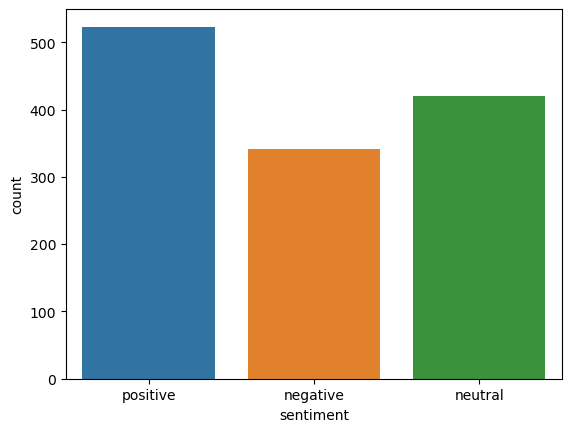

In [11]:
print(twts_lbl['sentiment'].value_counts())
sns.countplot(x=twts_lbl['sentiment'])
plt.show()

Frequency of different tweet lengths

/var/folders/k2/_q7jj7754nn3_3h7vr9wvn2c0000gn/T/ipykernel_5555/1934190635.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twts_lbl['length'] = twts_lbl['text'].apply(lambda x: len(x))


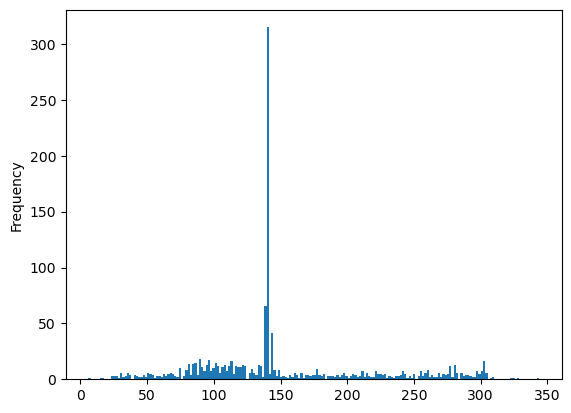

In [12]:
twts_lbl['length'] = twts_lbl['text'].apply(lambda x: len(x))
twts_lbl['length'].plot.hist(bins=200)
plt.show()

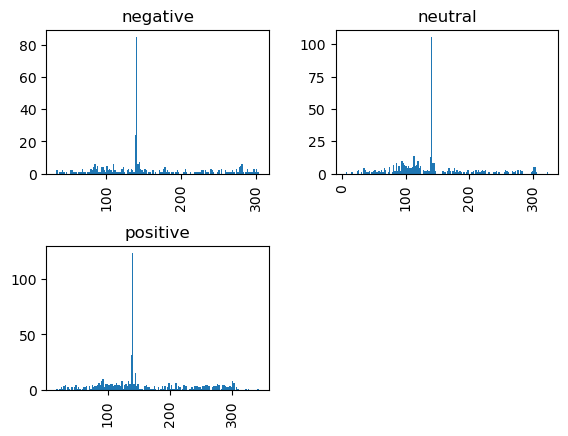

In [13]:
# length influence on sentiment
twts_lbl.hist(column='length', by='sentiment', bins=150)
plt.show()

In [14]:
ht_pattern = re.compile(r'#\w+')
ht_dic = collections.defaultdict(int)

In [15]:
for text in twts_lbl['text']:
    for word in text.split():
        word = word.lower()
        if ht_pattern.fullmatch(word) is not None:
            ht_dic[word] += 1

In [16]:
ht_df = pd.DataFrame.from_dict(
    ht_dic, orient='index').rename(columns={0: 'count'}) \
    .sort_values('count', ascending=False).head(20)

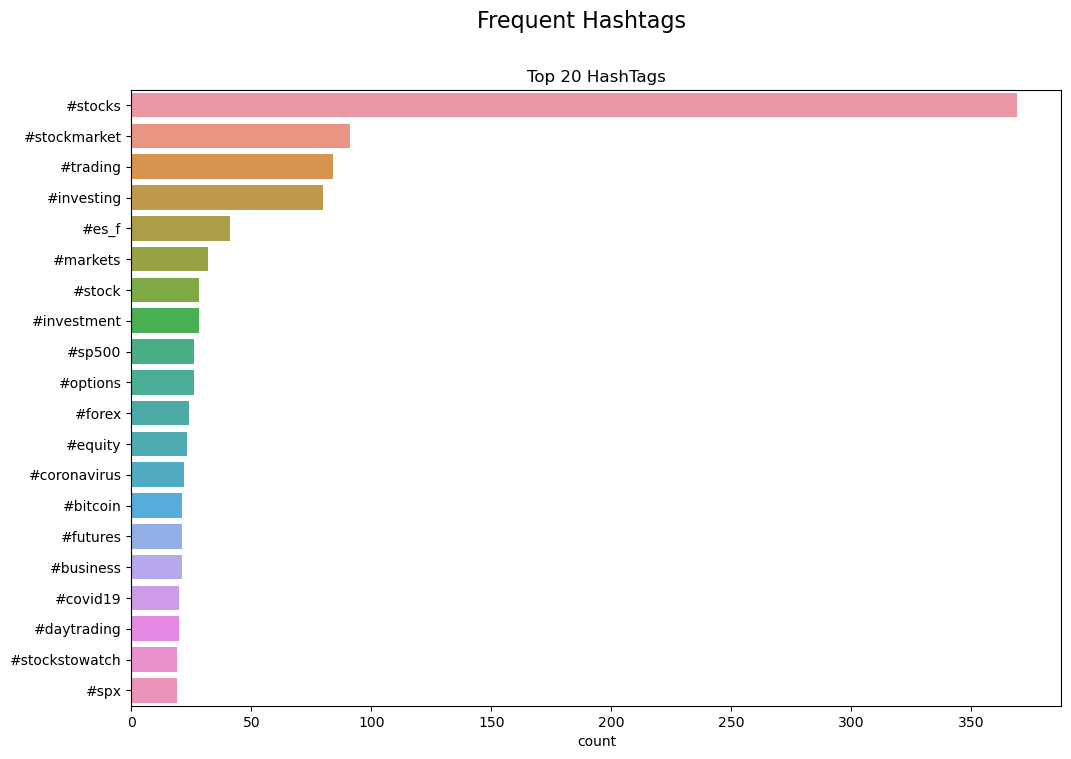

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
plt.suptitle('Frequent Hashtags', fontsize=16)
plt.subplots_adjust(wspace=0.4)
sns.barplot(x=ht_df['count'], y=ht_df.index, orient='h', ax=ax)
ax.set_title('Top 20 HashTags')
plt.show()

### Data Cleaning

In ths section, the dataset was cleaned from characteristics of tweets (usage of handles, retweets, special characters, emojis) in order to facilitate the processing of the text.

In this stage, the data cleaning involved:
- Remove handles from tweets
- Remove retweets (RT)
- Replace URLs with codeword links --> later removed for feature selection
- Remove special characters
- Replace emojis with their description
- Remove stopwords
- De-duplication of tweets
- Tokenization

Remove @user from all the tweets

In [18]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

# remove twitter handles (@user)
df_labelled['text'] = np.vectorize(remove_pattern)(df_labelled['text'], "@[\w]*")
df_labelled.head()

,id,created_at,text,sentiment
0,77522,2020-04-15 01:03:46+00:00,"RT : Yo💥\nEnter to WIN 1,000 Monarch Tokens✅\n...",positive
1,661634,2020-06-25 06:20:06+00:00,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,negative
2,413231,2020-06-04 15:41:45+00:00,Net issuance increases to fund fiscal programs...,positive
3,760262,2020-07-03 19:39:35+00:00,RT : How much of Amazon's traffic is served by...,positive
4,830153,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive


Remove retweet message (RT, retweet, etc)

In [19]:
df_labelled['text'] = np.vectorize(remove_pattern)(df_labelled['text'], "RT :")
df_labelled.head()

,id,created_at,text,sentiment
0,77522,2020-04-15 01:03:46+00:00,"Yo💥\nEnter to WIN 1,000 Monarch Tokens✅\n\nUS...",positive
1,661634,2020-06-25 06:20:06+00:00,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,negative
2,413231,2020-06-04 15:41:45+00:00,Net issuance increases to fund fiscal programs...,positive
3,760262,2020-07-03 19:39:35+00:00,How much of Amazon's traffic is served by Fas...,positive
4,830153,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive


Replace URL with word Link - Replaced wit space

In [20]:
pattern = r'(https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%.+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}[-a-zA-Z0-9()@:%+.~#?&/=]*)'

df_labelled['text'] = df_labelled['text'].str.replace(pattern, ' ', regex=True)
# df_labelled.head(10)

pattern2 = r'(?:^|\W)link(?:$|\W)'
df_labelled['text'] = df_labelled['text'].str.replace(pattern2, ' ', regex=True)
df_labelled.head()

,id,created_at,text,sentiment
0,77522,2020-04-15 01:03:46+00:00,"Yo💥\nEnter to WIN 1,000 Monarch Tokens✅\n\nUS...",positive
1,661634,2020-06-25 06:20:06+00:00,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,negative
2,413231,2020-06-04 15:41:45+00:00,Net issuance increases to fund fiscal programs...,positive
3,760262,2020-07-03 19:39:35+00:00,How much of Amazon's traffic is served by Fas...,positive
4,830153,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive


Change all the tweets into lowercase

In [21]:
df_labelled['text'] = df_labelled['text'].apply(lambda x: x.lower())
df_labelled.head()

,id,created_at,text,sentiment
0,77522,2020-04-15 01:03:46+00:00,"yo💥\nenter to win 1,000 monarch tokens✅\n\nus...",positive
1,661634,2020-06-25 06:20:06+00:00,#srilanka surcharge on fuel removed!\n⛽📉\nthe ...,negative
2,413231,2020-06-04 15:41:45+00:00,net issuance increases to fund fiscal programs...,positive
3,760262,2020-07-03 19:39:35+00:00,how much of amazon's traffic is served by fas...,positive
4,830153,2020-07-09 14:39:14+00:00,$amd ryzen 4000 desktop cpus looking ‘great’ a...,positive


Replace \n with space

In [22]:
df_labelled['text'] = df_labelled['text'].str.replace('\n', ' ', regex=True)
df_labelled.head()

,id,created_at,text,sentiment
0,77522,2020-04-15 01:03:46+00:00,"yo💥 enter to win 1,000 monarch tokens✅ us st...",positive
1,661634,2020-06-25 06:20:06+00:00,#srilanka surcharge on fuel removed! ⛽📉 the su...,negative
2,413231,2020-06-04 15:41:45+00:00,net issuance increases to fund fiscal programs...,positive
3,760262,2020-07-03 19:39:35+00:00,how much of amazon's traffic is served by fas...,positive
4,830153,2020-07-09 14:39:14+00:00,$amd ryzen 4000 desktop cpus looking ‘great’ a...,positive


Replace emoj with emoji description

In [23]:
df_noemojis = df_labelled

st = time.time()
for i in range(len(df_labelled)):
    df_labelled.loc[i, ['text']] = emoji.demojize(df_labelled['text'][i], delimiters=(" ", " ")) 
et = time.time()

elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

df_labelled

Execution time: 6.397221088409424 seconds


,id,created_at,text,sentiment
0,77522,2020-04-15 01:03:46+00:00,"yo collision enter to win 1,000 monarch toke...",positive
1,661634,2020-06-25 06:20:06+00:00,#srilanka surcharge on fuel removed! fuel_pum...,negative
2,413231,2020-06-04 15:41:45+00:00,net issuance increases to fund fiscal programs...,positive
3,760262,2020-07-03 19:39:35+00:00,how much of amazon's traffic is served by fas...,positive
4,830153,2020-07-09 14:39:14+00:00,$amd ryzen 4000 desktop cpus looking ‘great’ a...,positive
...,...,...,...,...
4838,411380,2020-06-04 18:14:57+00:00,"with ad revenues falling, what’s the impact on...",NaN
4839,62318,2020-04-14 02:15:01+00:00,well another point to add to dent the current...,NaN
4840,627230,2020-06-23 14:08:15+00:00,$itox working on a contract with a fortune 500...,NaN
4841,890123,2020-07-14 23:18:34+00:00,"$dis it could break the 120 pin, then 125&gt; ...",NaN


Replace _ (added by demojization) with space

In [24]:
df_labelled['text'] = df_labelled['text'].str.replace('_', ' ', regex=True)
df_labelled.head()

rws = df_labelled.loc[:, ['id','created_at', 'text', 'sentiment']]

Remove contractions

In [25]:
rws['text'] = rws['text'].apply(lambda x: [contractions.fix(word) for word in x.split()])
rws.head()

,id,created_at,text,sentiment
0,77522,2020-04-15 01:03:46+00:00,"[yo, collision, enter, to, win, 1,000, monarch...",positive
1,661634,2020-06-25 06:20:06+00:00,"[#srilanka, surcharge, on, fuel, removed!, fue...",negative
2,413231,2020-06-04 15:41:45+00:00,"[net, issuance, increases, to, fund, fiscal, p...",positive
3,760262,2020-07-03 19:39:35+00:00,"[how, much, of, amazon's, traffic, is, served,...",positive
4,830153,2020-07-09 14:39:14+00:00,"[$amd, ryzen, 4000, desktop, cpus, looking, ‘g...",positive


Return spaces between words

In [26]:
rws['text'] = [' '.join(map(str, l)) for l in rws['text']]
rws.head()

,id,created_at,text,sentiment
0,77522,2020-04-15 01:03:46+00:00,"yo collision enter to win 1,000 monarch tokens...",positive
1,661634,2020-06-25 06:20:06+00:00,#srilanka surcharge on fuel removed! fuel pump...,negative
2,413231,2020-06-04 15:41:45+00:00,net issuance increases to fund fiscal programs...,positive
3,760262,2020-07-03 19:39:35+00:00,how much of amazon's traffic is served by fast...,positive
4,830153,2020-07-09 14:39:14+00:00,$amd ryzen 4000 desktop cpus looking ‘great’ a...,positive


Download packages

In [27]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /Users/mbpro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mbpro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mbpro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Remove punctuation

In [28]:
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text
rws['text'] = rws['text'].apply(remove_punctuations)
rws.head()

,id,created_at,text,sentiment
0,77522,2020-04-15 01:03:46+00:00,yo collision enter to win 1000 monarch tokens ...,positive
1,661634,2020-06-25 06:20:06+00:00,srilanka surcharge on fuel removed fuel pump c...,negative
2,413231,2020-06-04 15:41:45+00:00,net issuance increases to fund fiscal programs...,positive
3,760262,2020-07-03 19:39:35+00:00,how much of amazons traffic is served by fastl...,positive
4,830153,2020-07-09 14:39:14+00:00,amd ryzen 4000 desktop cpus looking ‘great’ an...,positive


Remove Stopwords

In [29]:
stop_words = set(stopwords.words('english'))
rws['text'] = rws['text'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop_words))
rws.head()

,id,created_at,text,sentiment
0,77522,2020-04-15 01:03:46+00:00,yo collision enter win 1000 monarch tokens che...,positive
1,661634,2020-06-25 06:20:06+00:00,srilanka surcharge fuel removed fuel pump char...,negative
2,413231,2020-06-04 15:41:45+00:00,net issuance increases fund fiscal programs gt...,positive
3,760262,2020-07-03 19:39:35+00:00,much amazons traffic served fastly help us fin...,positive
4,830153,2020-07-09 14:39:14+00:00,amd ryzen 4000 desktop cpus looking ‘great’ tr...,positive


Lemmatization

In [30]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    words = text.split()
    words = [lemmatizer.lemmatize(word,pos='v') for word in words]
    return ' '.join(words)

rws['text'] = rws['text'].apply(lemmatize_words)
rws.head()

,id,created_at,text,sentiment
0,77522,2020-04-15 01:03:46+00:00,yo collision enter win 1000 monarch tokens che...,positive
1,661634,2020-06-25 06:20:06+00:00,srilanka surcharge fuel remove fuel pump chart...,negative
2,413231,2020-06-04 15:41:45+00:00,net issuance increase fund fiscal program gt y...,positive
3,760262,2020-07-03 19:39:35+00:00,much amazons traffic serve fastly help us find...,positive
4,830153,2020-07-09 14:39:14+00:00,amd ryzen 4000 desktop cpus look ‘great’ track...,positive


De-duplicate... again..

In [31]:
rws = rws.drop_duplicates(subset=['text'], ignore_index = True)
rws.describe(include="all")

,id,created_at,text,sentiment
count,4812.000000,4812,4812,1279
unique,NaN,4812,4812,3
top,NaN,2020-04-15 01:03:46+00:00,yo collision enter win 1000 monarch tokens che...,positive
freq,NaN,1,1,521
mean,469573.535121,NaN,NaN,NaN
std,268936.206772,NaN,NaN,NaN
min,11.000000,NaN,NaN,NaN
25%,241242.500000,NaN,NaN,NaN
50%,468626.500000,NaN,NaN,NaN
75%,700641.000000,NaN,NaN,NaN


In [32]:
# pip install wordcloud

In [33]:
from wordcloud import WordCloud

In [34]:
words = ' '.join([text for text in rws['text']])

In [35]:
wordcloud = WordCloud(
    width=800, height=400, background_color='white', max_font_size=110)\
    .generate(words)

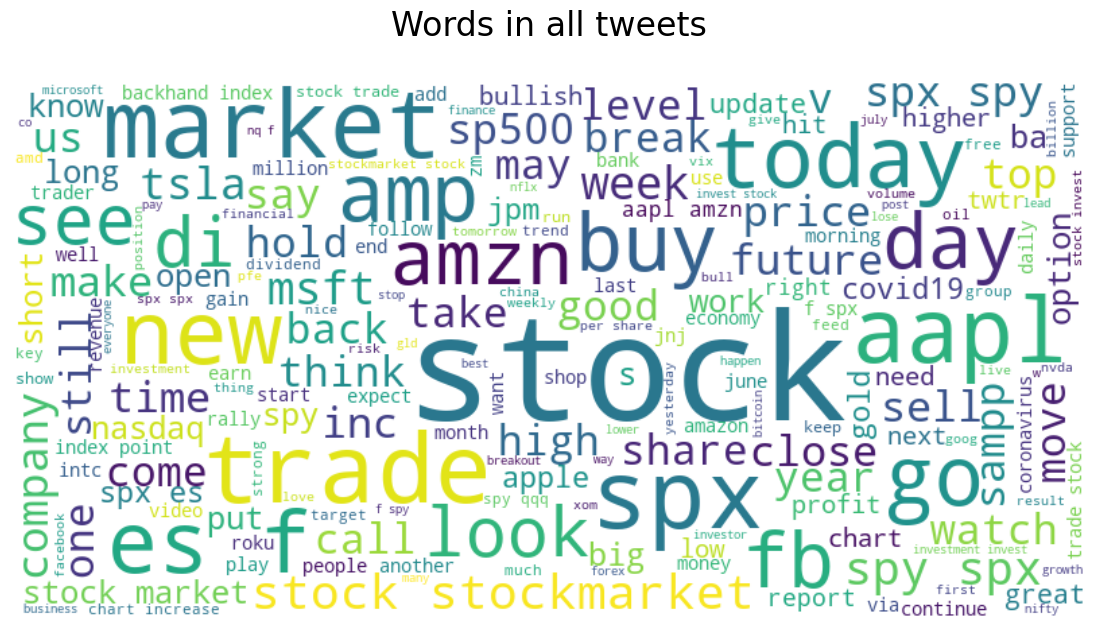

In [36]:
plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Words in all tweets\n', fontsize=24)
plt.axis('off')
plt.show()

### Data Splitting for Binary classification - Separate data into annotated data and unannotated data

In [37]:
rws['sentiment'].unique()

array(['positive', 'negative', 'neutral', nan], dtype=object)

In [38]:
# subset of data with manually labelled sentiment
labels = ['positive','negative']
rws_labelled = rws.loc[rws['sentiment'].isin(labels)]
rws_labelled.head()

,id,created_at,text,sentiment
0,77522,2020-04-15 01:03:46+00:00,yo collision enter win 1000 monarch tokens che...,positive
1,661634,2020-06-25 06:20:06+00:00,srilanka surcharge fuel remove fuel pump chart...,negative
2,413231,2020-06-04 15:41:45+00:00,net issuance increase fund fiscal program gt y...,positive
3,760262,2020-07-03 19:39:35+00:00,much amazons traffic serve fastly help us find...,positive
4,830153,2020-07-09 14:39:14+00:00,amd ryzen 4000 desktop cpus look ‘great’ track...,positive


In [39]:
rws_labelled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 862 entries, 0 to 1278
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          862 non-null    int64 
 1   created_at  862 non-null    object
 2   text        862 non-null    object
 3   sentiment   862 non-null    object
dtypes: int64(1), object(3)
memory usage: 33.7+ KB


In [40]:
# subset of data without manually labelled sentiment
rws_not_labelled = rws[rws['sentiment'].isnull()]
rws_not_labelled.head()

,id,created_at,text,sentiment
1279,254563,2020-04-29 01:57:02+00:00,get share bamboo aapl msft jpm tsla also compo...,NaN
1280,280832,2020-05-05 17:58:44+00:00,hamps form 4h chart spx spy,NaN
1281,672447,2020-06-26 15:29:14+00:00,happen fb,NaN
1282,146759,2020-04-21 11:53:54+00:00,aapl expand service business market africa beyond,NaN
1283,116538,2020-04-19 23:34:14+00:00,spx spx es f nq rut dax ftse es f qqq dow like...,NaN


In [41]:
rws_not_labelled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3533 entries, 1279 to 4811
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          3533 non-null   int64 
 1   created_at  3533 non-null   object
 2   text        3533 non-null   object
 3   sentiment   0 non-null      object
dtypes: int64(1), object(3)
memory usage: 138.0+ KB


In [42]:
training_data, testing_data = train_test_split(rws_labelled, test_size=0.2, random_state=25)

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 689
No. of testing examples: 173


In [43]:
x_train = list(training_data['text'])
y_train = list(training_data['sentiment'])

x_test = list(testing_data['text'])
y_test = list(testing_data['sentiment'])

x_not_labelled = list(rws_not_labelled['text'])

In [44]:
len(x_not_labelled)

3533

In [45]:
len(x_train),len(y_train),len(x_test),len(y_test)

(689, 689, 173, 173)

In [46]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
import numpy as np
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.multiclass import OneVsOneClassifier

# Binary classification


## Classifier: SVC

In [47]:
bin_pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=5)),  # feature extraction
    ('sel', SelectKBest(chi2, k=20)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

bin_pipeline.fit(x_train,y_train)
bin_predictions = bin_pipeline.predict(x_test)

print('Classification report:')
print(classification_report(y_test, bin_predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, bin_predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

    negative       0.72      0.45      0.55        73
    positive       0.69      0.87      0.77       100

    accuracy                           0.69       173
   macro avg       0.70      0.66      0.66       173
weighted avg       0.70      0.69      0.68       173

Confusion matrix:
[[33 40]
 [13 87]]


In [48]:
pred_not_labelled_SVC_bin = bin_pipeline.predict(x_not_labelled)

In [49]:
len(pred_not_labelled_SVC_bin)

3533

In [50]:
pred_not_labelled_SVC_bin

array(['positive', 'negative', 'positive', ..., 'negative', 'positive',
       'negative'], dtype='<U8')

In [51]:
np.unique(pred_not_labelled_SVC_bin)

array(['negative', 'positive'], dtype='<U8')

In [52]:
rws_not_labelled['svc_sent'] = pred_not_labelled_SVC_bin.tolist()

/var/folders/k2/_q7jj7754nn3_3h7vr9wvn2c0000gn/T/ipykernel_5555/190065401.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rws_not_labelled['svc_sent'] = pred_not_labelled_SVC_bin.tolist()


In [53]:
rws_not_labelled

,id,created_at,text,sentiment,svc_sent
1279,254563,2020-04-29 01:57:02+00:00,get share bamboo aapl msft jpm tsla also compo...,NaN,positive
1280,280832,2020-05-05 17:58:44+00:00,hamps form 4h chart spx spy,NaN,negative
1281,672447,2020-06-26 15:29:14+00:00,happen fb,NaN,positive
1282,146759,2020-04-21 11:53:54+00:00,aapl expand service business market africa beyond,NaN,positive
1283,116538,2020-04-19 23:34:14+00:00,spx spx es f nq rut dax ftse es f qqq dow like...,NaN,negative
...,...,...,...,...,...
4807,411380,2020-06-04 18:14:57+00:00,ad revenues fall impact social media stock fb ...,NaN,positive
4808,62318,2020-04-14 02:15:01+00:00,well another point add dent current optimism s...,NaN,positive
4809,627230,2020-06-23 14:08:15+00:00,itox work contract fortune 500 aerospace firm ...,NaN,negative
4810,890123,2020-07-14 23:18:34+00:00,dis could break 120 pin 125gt 130,NaN,positive


## Classifier: Decision Tree

In [54]:
dt_bin_pipeline = Pipeline([
    ('vect', CountVectorizer()),  # feature extraction
    ('sel', SelectKBest(chi2, k=20)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', DecisionTreeClassifier())  # learning algorithm
])

dt_bin_pipeline.fit(x_train,y_train)
bin_predictions = dt_bin_pipeline.predict(x_test)

print('Classification report:')
print(classification_report(y_test, bin_predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, bin_predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

    negative       0.70      0.45      0.55        73
    positive       0.68      0.86      0.76       100

    accuracy                           0.69       173
   macro avg       0.69      0.66      0.66       173
weighted avg       0.69      0.69      0.67       173

Confusion matrix:
[[33 40]
 [14 86]]


In [55]:
pred_not_labelled_DT_bin = dt_bin_pipeline.predict(x_not_labelled)

We can try to visualize the tree, but there are too many dimension to have a structure that is really inspectable (I'm referring to the font size, but to the number of nodes of the tree!).

DT visualization works on low dimensional data (see https://scikit-learn.org/stable/modules/tree.html#classification)

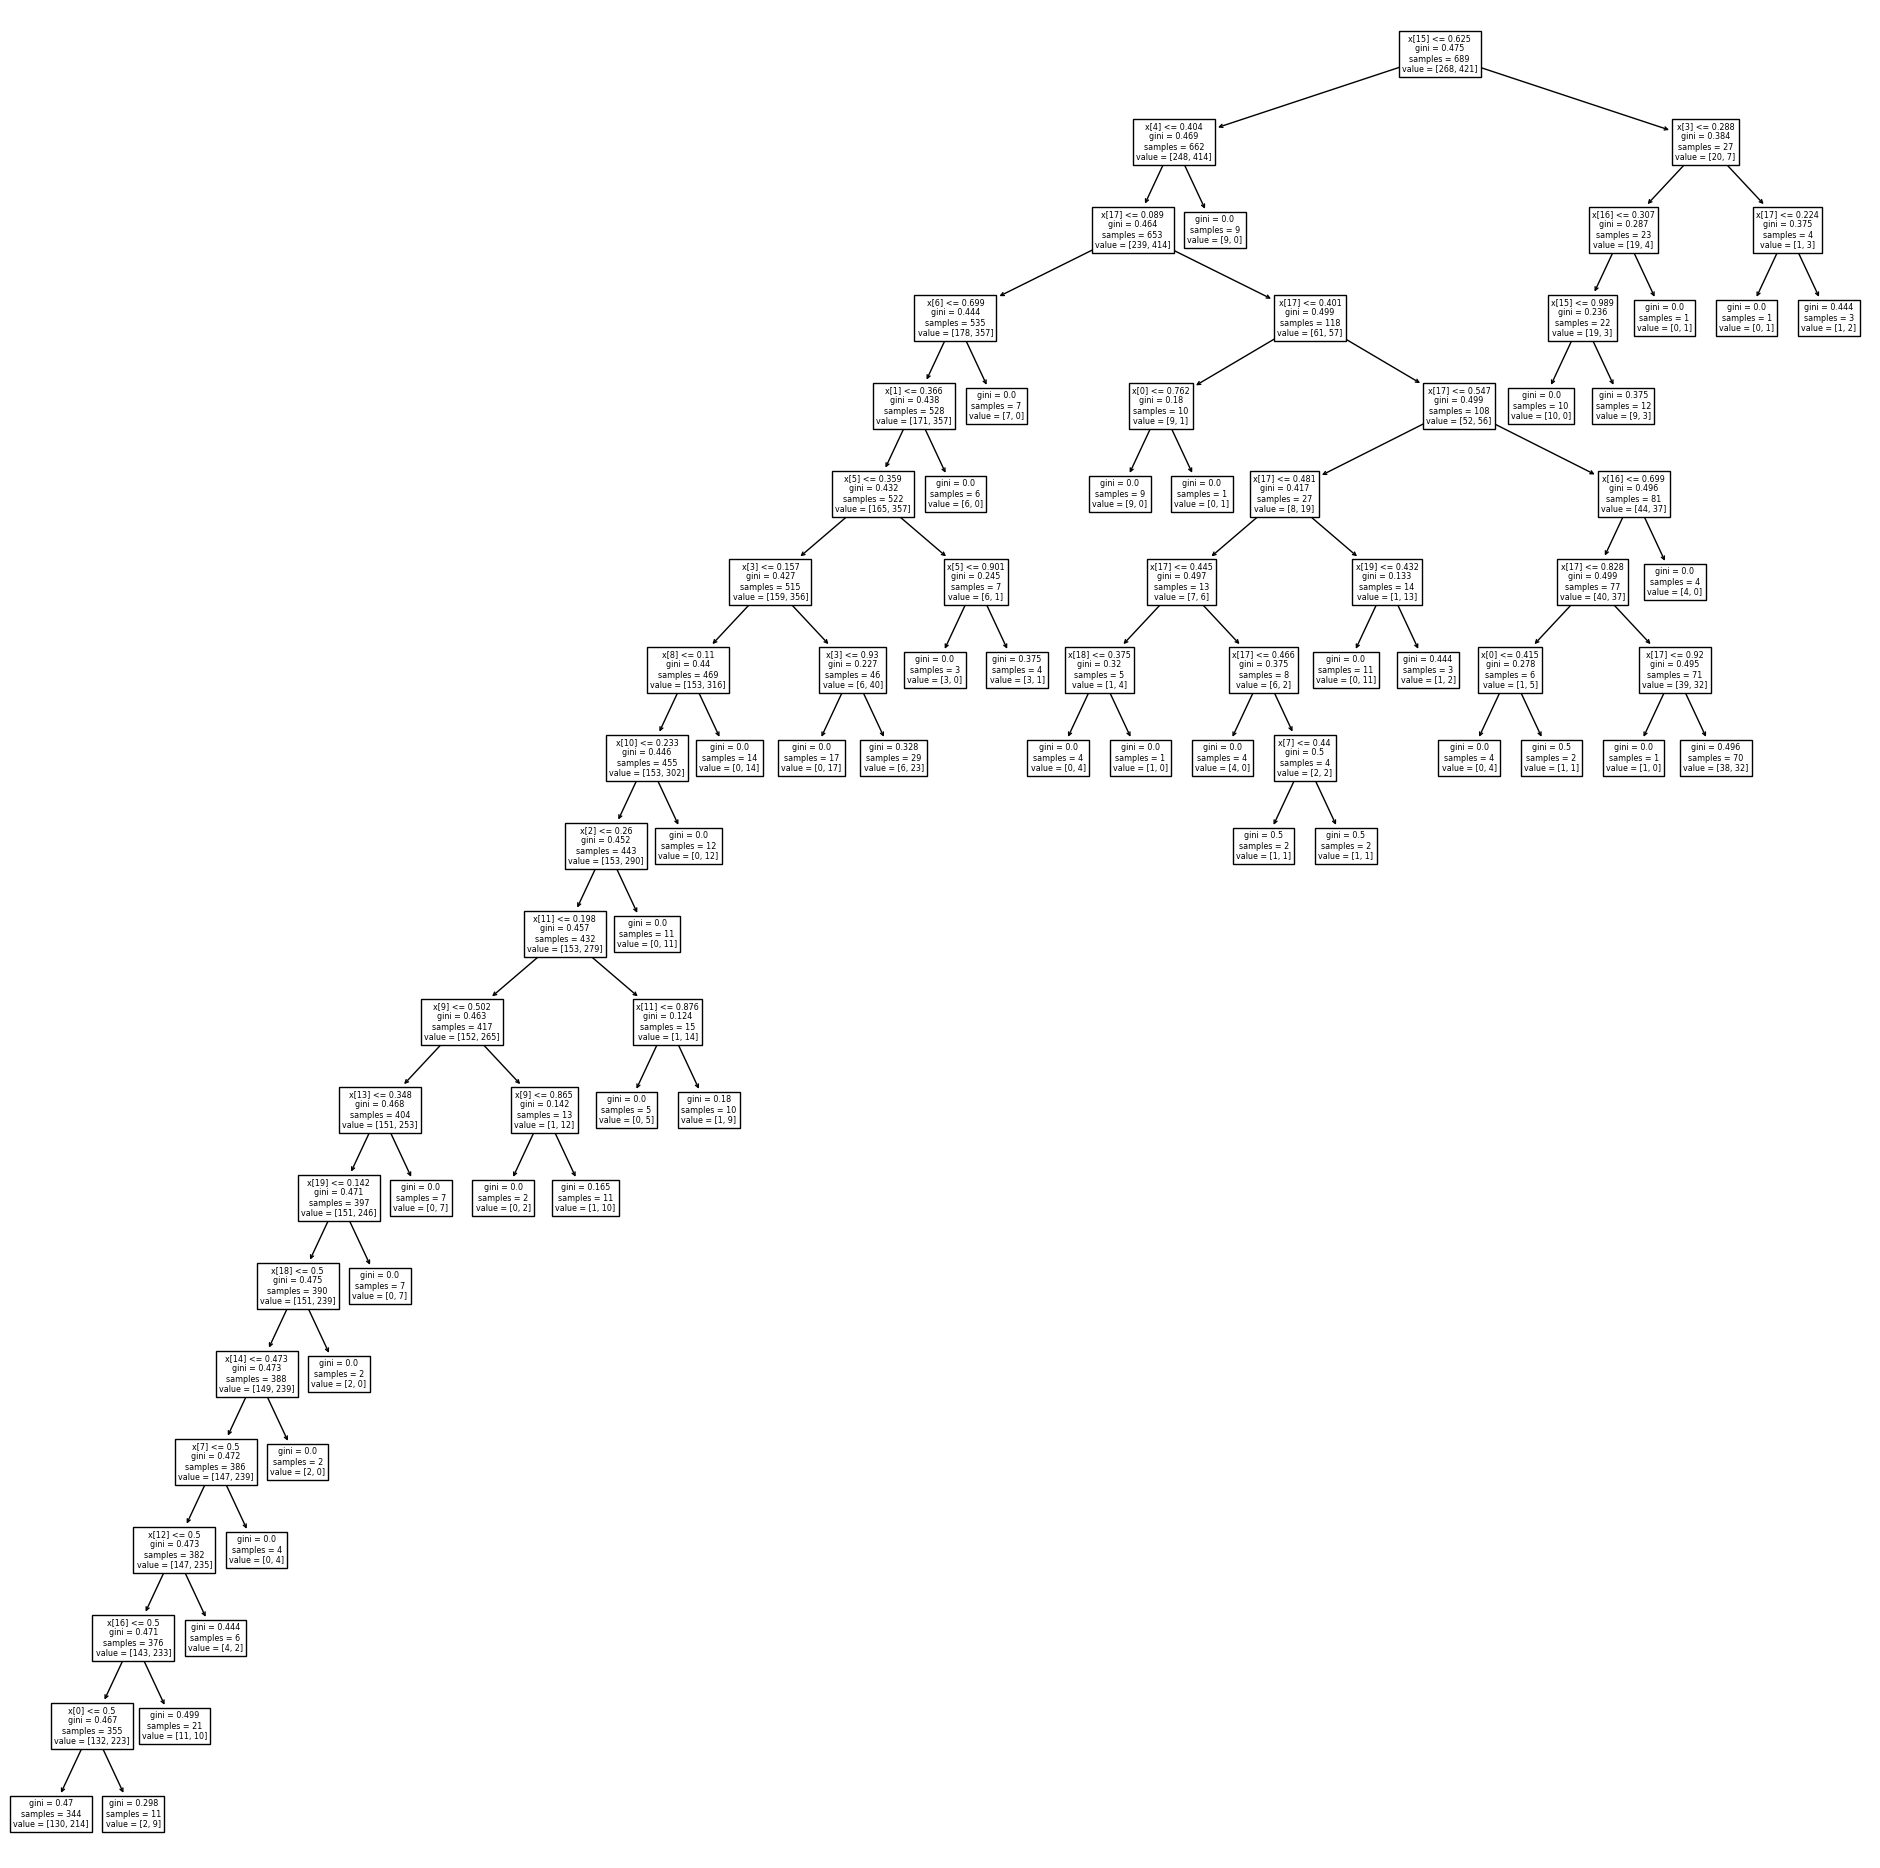

In [56]:
fig, ax = plt.subplots(figsize=(24, 24))
plot_tree(dt_bin_pipeline.named_steps['learner'])
plt.show()

In [57]:
rws_not_labelled['DT_sent'] = pred_not_labelled_DT_bin.tolist()

/var/folders/k2/_q7jj7754nn3_3h7vr9wvn2c0000gn/T/ipykernel_5555/408954101.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rws_not_labelled['DT_sent'] = pred_not_labelled_DT_bin.tolist()


In [58]:
rws_not_labelled

,id,created_at,text,sentiment,svc_sent,DT_sent
1279,254563,2020-04-29 01:57:02+00:00,get share bamboo aapl msft jpm tsla also compo...,NaN,positive,positive
1280,280832,2020-05-05 17:58:44+00:00,hamps form 4h chart spx spy,NaN,negative,negative
1281,672447,2020-06-26 15:29:14+00:00,happen fb,NaN,positive,positive
1282,146759,2020-04-21 11:53:54+00:00,aapl expand service business market africa beyond,NaN,positive,positive
1283,116538,2020-04-19 23:34:14+00:00,spx spx es f nq rut dax ftse es f qqq dow like...,NaN,negative,negative
...,...,...,...,...,...,...
4807,411380,2020-06-04 18:14:57+00:00,ad revenues fall impact social media stock fb ...,NaN,positive,positive
4808,62318,2020-04-14 02:15:01+00:00,well another point add dent current optimism s...,NaN,positive,positive
4809,627230,2020-06-23 14:08:15+00:00,itox work contract fortune 500 aerospace firm ...,NaN,negative,negative
4810,890123,2020-07-14 23:18:34+00:00,dis could break 120 pin 125gt 130,NaN,positive,positive


## Classifier: Naive Bayes

NB uses a multinomial model based on term frequencies, we can skip the tfidf module.

In [59]:
nb_bin_pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=5)),  # feature extraction
    ('sel', SelectKBest(chi2, k=20)),  # feature selection
    ('learner', MultinomialNB())  # learning algorithm
])

nb_bin_pipeline.fit(x_train,y_train)
bin_predictions = nb_bin_pipeline.predict(x_test)

print('Classification report:')
print(classification_report(y_test, bin_predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, bin_predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

    negative       0.72      0.45      0.55        73
    positive       0.69      0.87      0.77       100

    accuracy                           0.69       173
   macro avg       0.70      0.66      0.66       173
weighted avg       0.70      0.69      0.68       173

Confusion matrix:
[[33 40]
 [13 87]]


In [60]:
pred_not_labelled_NB_bin = nb_bin_pipeline.predict(x_not_labelled)

In [61]:
rws_not_labelled['NB_sent'] = pred_not_labelled_NB_bin.tolist()
rws_not_labelled

/var/folders/k2/_q7jj7754nn3_3h7vr9wvn2c0000gn/T/ipykernel_5555/2595686124.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rws_not_labelled['NB_sent'] = pred_not_labelled_NB_bin.tolist()


,id,created_at,text,sentiment,svc_sent,DT_sent,NB_sent
1279,254563,2020-04-29 01:57:02+00:00,get share bamboo aapl msft jpm tsla also compo...,NaN,positive,positive,positive
1280,280832,2020-05-05 17:58:44+00:00,hamps form 4h chart spx spy,NaN,negative,negative,negative
1281,672447,2020-06-26 15:29:14+00:00,happen fb,NaN,positive,positive,positive
1282,146759,2020-04-21 11:53:54+00:00,aapl expand service business market africa beyond,NaN,positive,positive,positive
1283,116538,2020-04-19 23:34:14+00:00,spx spx es f nq rut dax ftse es f qqq dow like...,NaN,negative,negative,negative
...,...,...,...,...,...,...,...
4807,411380,2020-06-04 18:14:57+00:00,ad revenues fall impact social media stock fb ...,NaN,positive,positive,positive
4808,62318,2020-04-14 02:15:01+00:00,well another point add dent current optimism s...,NaN,positive,positive,positive
4809,627230,2020-06-23 14:08:15+00:00,itox work contract fortune 500 aerospace firm ...,NaN,negative,negative,negative
4810,890123,2020-07-14 23:18:34+00:00,dis could break 120 pin 125gt 130,NaN,positive,positive,positive


# Multi-class single-label classification

Tokenization does not change from the binary problem, as the dataset is the same.

### Data Splitting for Multi-Class classification - Separate data into annotated data and unannotated data

In [62]:
rws['sentiment'].unique()

array(['positive', 'negative', 'neutral', nan], dtype=object)

In [63]:
# subset of data with manually labelled sentiment
labels = ['positive','negative', 'neutral']
rws_labelled = rws.loc[rws['sentiment'].isin(labels)]
rws_labelled.head()

,id,created_at,text,sentiment
0,77522,2020-04-15 01:03:46+00:00,yo collision enter win 1000 monarch tokens che...,positive
1,661634,2020-06-25 06:20:06+00:00,srilanka surcharge fuel remove fuel pump chart...,negative
2,413231,2020-06-04 15:41:45+00:00,net issuance increase fund fiscal program gt y...,positive
3,760262,2020-07-03 19:39:35+00:00,much amazons traffic serve fastly help us find...,positive
4,830153,2020-07-09 14:39:14+00:00,amd ryzen 4000 desktop cpus look ‘great’ track...,positive


In [64]:
# subset of data without manually labelled sentiment
rws_not_labelled = rws[rws['sentiment'].isnull()]
rws_not_labelled.head()

,id,created_at,text,sentiment
1279,254563,2020-04-29 01:57:02+00:00,get share bamboo aapl msft jpm tsla also compo...,NaN
1280,280832,2020-05-05 17:58:44+00:00,hamps form 4h chart spx spy,NaN
1281,672447,2020-06-26 15:29:14+00:00,happen fb,NaN
1282,146759,2020-04-21 11:53:54+00:00,aapl expand service business market africa beyond,NaN
1283,116538,2020-04-19 23:34:14+00:00,spx spx es f nq rut dax ftse es f qqq dow like...,NaN


In [65]:
training_data, testing_data = train_test_split(rws_labelled, test_size=0.2, random_state=25)

print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 1023
No. of testing examples: 256


In [66]:
x_train = list(training_data['text'])
y_train = list(training_data['sentiment'])

x_test = list(testing_data['text'])
y_test = list(testing_data['sentiment'])

In [67]:
len(x_train),len(y_train),len(x_test),len(y_test)

(1023, 1023, 256, 256)

## Classifier: SVC

In [68]:
pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=5)),  # feature extraction
    ('sel', SelectKBest(chi2, k=40)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

classifier = pipeline.fit(x_train,y_train)
predictions = classifier.predict(x_test)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

    negative       0.82      0.37      0.51        73
     neutral       0.42      0.86      0.56        76
    positive       0.64      0.40      0.49       107

    accuracy                           0.53       256
   macro avg       0.63      0.54      0.52       256
weighted avg       0.63      0.53      0.52       256

Confusion matrix:
[[27 31 15]
 [ 2 65  9]
 [ 4 60 43]]


In [69]:
pred_not_labelled_SVC_mul = classifier.predict(x_not_labelled)

In [70]:
rws_not_labelled['SVC_mul_sent'] = pred_not_labelled_SVC_mul.tolist()
rws_not_labelled

/var/folders/k2/_q7jj7754nn3_3h7vr9wvn2c0000gn/T/ipykernel_5555/1253957586.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rws_not_labelled['SVC_mul_sent'] = pred_not_labelled_SVC_mul.tolist()


,id,created_at,text,sentiment,SVC_mul_sent
1279,254563,2020-04-29 01:57:02+00:00,get share bamboo aapl msft jpm tsla also compo...,NaN,neutral
1280,280832,2020-05-05 17:58:44+00:00,hamps form 4h chart spx spy,NaN,neutral
1281,672447,2020-06-26 15:29:14+00:00,happen fb,NaN,neutral
1282,146759,2020-04-21 11:53:54+00:00,aapl expand service business market africa beyond,NaN,neutral
1283,116538,2020-04-19 23:34:14+00:00,spx spx es f nq rut dax ftse es f qqq dow like...,NaN,neutral
...,...,...,...,...,...
4807,411380,2020-06-04 18:14:57+00:00,ad revenues fall impact social media stock fb ...,NaN,positive
4808,62318,2020-04-14 02:15:01+00:00,well another point add dent current optimism s...,NaN,neutral
4809,627230,2020-06-23 14:08:15+00:00,itox work contract fortune 500 aerospace firm ...,NaN,neutral
4810,890123,2020-07-14 23:18:34+00:00,dis could break 120 pin 125gt 130,NaN,neutral


The classification score for the binary classifier we learned earlier is different, though it is trained on exactly the same data. Why?

We try a linear svm with one-vs-one model.

LinearSVC does not implement OvO.

We can wrap it into a OneVsOneClassifier that can be applied to any classifier.

(Note that other classifiers natively implement OvO, e.g., sklearn.svm.SVC)

In [71]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),  # feature extraction
    ('sel', SelectKBest(chi2, k=40)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', OneVsOneClassifier(LinearSVC()))  # learning algorithm
])

classifier = pipeline.fit(x_train,y_train)
predictions = classifier.predict(x_test)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

    negative       0.76      0.36      0.49        73
     neutral       0.39      0.84      0.53        76
    positive       0.59      0.31      0.40       107

    accuracy                           0.48       256
   macro avg       0.58      0.50      0.47       256
weighted avg       0.58      0.48      0.46       256

Confusion matrix:
[[26 35 12]
 [ 1 64 11]
 [ 7 67 33]]


In [72]:
pred_not_labelled_OVO_mul = classifier.predict(x_not_labelled)

In [73]:
rws_not_labelled['OVO_mul_sent'] = pred_not_labelled_OVO_mul.tolist()
rws_not_labelled

/var/folders/k2/_q7jj7754nn3_3h7vr9wvn2c0000gn/T/ipykernel_5555/3534092537.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rws_not_labelled['OVO_mul_sent'] = pred_not_labelled_OVO_mul.tolist()


,id,created_at,text,sentiment,SVC_mul_sent,OVO_mul_sent
1279,254563,2020-04-29 01:57:02+00:00,get share bamboo aapl msft jpm tsla also compo...,NaN,neutral,neutral
1280,280832,2020-05-05 17:58:44+00:00,hamps form 4h chart spx spy,NaN,neutral,neutral
1281,672447,2020-06-26 15:29:14+00:00,happen fb,NaN,neutral,neutral
1282,146759,2020-04-21 11:53:54+00:00,aapl expand service business market africa beyond,NaN,neutral,neutral
1283,116538,2020-04-19 23:34:14+00:00,spx spx es f nq rut dax ftse es f qqq dow like...,NaN,neutral,neutral
...,...,...,...,...,...,...
4807,411380,2020-06-04 18:14:57+00:00,ad revenues fall impact social media stock fb ...,NaN,positive,positive
4808,62318,2020-04-14 02:15:01+00:00,well another point add dent current optimism s...,NaN,neutral,neutral
4809,627230,2020-06-23 14:08:15+00:00,itox work contract fortune 500 aerospace firm ...,NaN,neutral,neutral
4810,890123,2020-07-14 23:18:34+00:00,dis could break 120 pin 125gt 130,NaN,neutral,neutral


## Classifier: Decision Tree

In [74]:
dt_bin_pipeline = Pipeline([
    ('vect', CountVectorizer()),  # feature extraction
    ('sel', SelectKBest(chi2, k=40)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', DecisionTreeClassifier())  # learning algorithm
])

dt_bin_pipeline.fit(x_train,y_train)
bin_predictions = dt_bin_pipeline.predict(x_test)

print('Classification report:')
print(classification_report(y_test, bin_predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, bin_predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

    negative       0.83      0.33      0.47        73
     neutral       0.39      0.91      0.55        76
    positive       0.65      0.32      0.43       107

    accuracy                           0.50       256
   macro avg       0.63      0.52      0.48       256
weighted avg       0.63      0.50      0.48       256

Confusion matrix:
[[24 37 12]
 [ 1 69  6]
 [ 4 69 34]]


In [75]:
pred_not_labelled_DT_mul = dt_bin_pipeline.predict(x_not_labelled)

In [76]:
rws_not_labelled['DT_mul_sent'] = pred_not_labelled_DT_mul.tolist()
rws_not_labelled

/var/folders/k2/_q7jj7754nn3_3h7vr9wvn2c0000gn/T/ipykernel_5555/1959967025.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rws_not_labelled['DT_mul_sent'] = pred_not_labelled_DT_mul.tolist()


,id,created_at,text,sentiment,SVC_mul_sent,OVO_mul_sent,DT_mul_sent
1279,254563,2020-04-29 01:57:02+00:00,get share bamboo aapl msft jpm tsla also compo...,NaN,neutral,neutral,neutral
1280,280832,2020-05-05 17:58:44+00:00,hamps form 4h chart spx spy,NaN,neutral,neutral,neutral
1281,672447,2020-06-26 15:29:14+00:00,happen fb,NaN,neutral,neutral,neutral
1282,146759,2020-04-21 11:53:54+00:00,aapl expand service business market africa beyond,NaN,neutral,neutral,neutral
1283,116538,2020-04-19 23:34:14+00:00,spx spx es f nq rut dax ftse es f qqq dow like...,NaN,neutral,neutral,neutral
...,...,...,...,...,...,...,...
4807,411380,2020-06-04 18:14:57+00:00,ad revenues fall impact social media stock fb ...,NaN,positive,positive,positive
4808,62318,2020-04-14 02:15:01+00:00,well another point add dent current optimism s...,NaN,neutral,neutral,neutral
4809,627230,2020-06-23 14:08:15+00:00,itox work contract fortune 500 aerospace firm ...,NaN,neutral,neutral,neutral
4810,890123,2020-07-14 23:18:34+00:00,dis could break 120 pin 125gt 130,NaN,neutral,neutral,neutral


## Classifier: Naive Bayes

NB uses a multinomial model based on term frequencies, we can skip the tfidf module.

In [77]:
nb_bin_pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=5)),  # feature extraction
    ('sel', SelectKBest(chi2, k=40)),  # feature selection
    ('learner', MultinomialNB())  # learning algorithm
])

nb_bin_pipeline.fit(x_train,y_train)
bin_predictions = nb_bin_pipeline.predict(x_test)

print('Classification report:')
print(classification_report(y_test, bin_predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, bin_predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

    negative       0.76      0.34      0.47        73
     neutral       0.40      0.11      0.17        76
    positive       0.47      0.89      0.61       107

    accuracy                           0.50       256
   macro avg       0.54      0.45      0.42       256
weighted avg       0.53      0.50      0.44       256

Confusion matrix:
[[25  5 43]
 [ 3  8 65]
 [ 5  7 95]]


In [78]:
pred_not_labelled_NB_mul = nb_bin_pipeline.predict(x_not_labelled)

In [79]:
rws_not_labelled['NB_mul_sent'] = pred_not_labelled_NB_mul.tolist()
rws_not_labelled

/var/folders/k2/_q7jj7754nn3_3h7vr9wvn2c0000gn/T/ipykernel_5555/1521938041.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rws_not_labelled['NB_mul_sent'] = pred_not_labelled_NB_mul.tolist()


,id,created_at,text,sentiment,SVC_mul_sent,OVO_mul_sent,DT_mul_sent,NB_mul_sent
1279,254563,2020-04-29 01:57:02+00:00,get share bamboo aapl msft jpm tsla also compo...,NaN,neutral,neutral,neutral,positive
1280,280832,2020-05-05 17:58:44+00:00,hamps form 4h chart spx spy,NaN,neutral,neutral,neutral,positive
1281,672447,2020-06-26 15:29:14+00:00,happen fb,NaN,neutral,neutral,neutral,positive
1282,146759,2020-04-21 11:53:54+00:00,aapl expand service business market africa beyond,NaN,neutral,neutral,neutral,positive
1283,116538,2020-04-19 23:34:14+00:00,spx spx es f nq rut dax ftse es f qqq dow like...,NaN,neutral,neutral,neutral,neutral
...,...,...,...,...,...,...,...,...
4807,411380,2020-06-04 18:14:57+00:00,ad revenues fall impact social media stock fb ...,NaN,positive,positive,positive,positive
4808,62318,2020-04-14 02:15:01+00:00,well another point add dent current optimism s...,NaN,neutral,neutral,neutral,positive
4809,627230,2020-06-23 14:08:15+00:00,itox work contract fortune 500 aerospace firm ...,NaN,neutral,neutral,neutral,positive
4810,890123,2020-07-14 23:18:34+00:00,dis could break 120 pin 125gt 130,NaN,neutral,neutral,neutral,positive


## Get sentiment average from different classifier outputs

Change SVC mul to int

In [80]:
rws_not_labelled.loc[rws_not_labelled['SVC_mul_sent'] == 'positive', 'SVC_mul_sent'] = 1
rws_not_labelled.loc[rws_not_labelled['SVC_mul_sent'] == 'neutral', 'SVC_mul_sent'] = 0
rws_not_labelled.loc[rws_not_labelled['SVC_mul_sent'] == 'negative', 'SVC_mul_sent'] = -1

In [81]:
rws_not_labelled.loc[rws_not_labelled['OVO_mul_sent'] == 'positive', 'OVO_mul_sent'] = 1
rws_not_labelled.loc[rws_not_labelled['OVO_mul_sent'] == 'neutral', 'OVO_mul_sent'] = 0
rws_not_labelled.loc[rws_not_labelled['OVO_mul_sent'] == 'negative', 'OVO_mul_sent'] = -1

In [82]:
rws_not_labelled.loc[rws_not_labelled['DT_mul_sent'] == 'positive', 'DT_mul_sent'] = 1
rws_not_labelled.loc[rws_not_labelled['DT_mul_sent'] == 'neutral', 'DT_mul_sent'] = 0
rws_not_labelled.loc[rws_not_labelled['DT_mul_sent'] == 'negative', 'DT_mul_sent'] = -1

In [83]:
rws_not_labelled.loc[rws_not_labelled['NB_mul_sent'] == 'positive', 'NB_mul_sent'] = 1
rws_not_labelled.loc[rws_not_labelled['NB_mul_sent'] == 'neutral', 'NB_mul_sent'] = 0
rws_not_labelled.loc[rws_not_labelled['NB_mul_sent'] == 'negative', 'NB_mul_sent'] = -1

In [84]:
rws_not_labelled

,id,created_at,text,sentiment,SVC_mul_sent,OVO_mul_sent,DT_mul_sent,NB_mul_sent
1279,254563,2020-04-29 01:57:02+00:00,get share bamboo aapl msft jpm tsla also compo...,NaN,0,0,0,1
1280,280832,2020-05-05 17:58:44+00:00,hamps form 4h chart spx spy,NaN,0,0,0,1
1281,672447,2020-06-26 15:29:14+00:00,happen fb,NaN,0,0,0,1
1282,146759,2020-04-21 11:53:54+00:00,aapl expand service business market africa beyond,NaN,0,0,0,1
1283,116538,2020-04-19 23:34:14+00:00,spx spx es f nq rut dax ftse es f qqq dow like...,NaN,0,0,0,0
...,...,...,...,...,...,...,...,...
4807,411380,2020-06-04 18:14:57+00:00,ad revenues fall impact social media stock fb ...,NaN,1,1,1,1
4808,62318,2020-04-14 02:15:01+00:00,well another point add dent current optimism s...,NaN,0,0,0,1
4809,627230,2020-06-23 14:08:15+00:00,itox work contract fortune 500 aerospace firm ...,NaN,0,0,0,1
4810,890123,2020-07-14 23:18:34+00:00,dis could break 120 pin 125gt 130,NaN,0,0,0,1


In [85]:
rws_not_labelled['average_sent'] = rws_not_labelled[['SVC_mul_sent', 'OVO_mul_sent', 'DT_mul_sent']].mean(axis=1)
rws_not_labelled

/var/folders/k2/_q7jj7754nn3_3h7vr9wvn2c0000gn/T/ipykernel_5555/2953796680.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rws_not_labelled['average_sent'] = rws_not_labelled[['SVC_mul_sent', 'OVO_mul_sent', 'DT_mul_sent']].mean(axis=1)


,id,created_at,text,sentiment,SVC_mul_sent,OVO_mul_sent,DT_mul_sent,NB_mul_sent,average_sent
1279,254563,2020-04-29 01:57:02+00:00,get share bamboo aapl msft jpm tsla also compo...,NaN,0,0,0,1,0.0
1280,280832,2020-05-05 17:58:44+00:00,hamps form 4h chart spx spy,NaN,0,0,0,1,0.0
1281,672447,2020-06-26 15:29:14+00:00,happen fb,NaN,0,0,0,1,0.0
1282,146759,2020-04-21 11:53:54+00:00,aapl expand service business market africa beyond,NaN,0,0,0,1,0.0
1283,116538,2020-04-19 23:34:14+00:00,spx spx es f nq rut dax ftse es f qqq dow like...,NaN,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...
4807,411380,2020-06-04 18:14:57+00:00,ad revenues fall impact social media stock fb ...,NaN,1,1,1,1,1.0
4808,62318,2020-04-14 02:15:01+00:00,well another point add dent current optimism s...,NaN,0,0,0,1,0.0
4809,627230,2020-06-23 14:08:15+00:00,itox work contract fortune 500 aerospace firm ...,NaN,0,0,0,1,0.0
4810,890123,2020-07-14 23:18:34+00:00,dis could break 120 pin 125gt 130,NaN,0,0,0,1,0.0


Add sentiment to sentiment column

In [86]:
rws_not_labelled.loc[rws_not_labelled['average_sent'] > 0, 'sentiment'] = 'positive'
rws_not_labelled.loc[rws_not_labelled['average_sent'] == 0, 'sentiment'] = 'neutral'
rws_not_labelled.loc[rws_not_labelled['average_sent'] < 0 , 'sentiment'] = 'negative'

TextBlob for sentiment Analysis

In [87]:
from textblob import TextBlob

In [88]:
def stringToSentiment(text):
    return TextBlob(text).sentiment.polarity

In [89]:
rws_not_labelled['sent_polarity'] = rws_not_labelled['text'].apply(stringToSentiment)

/var/folders/k2/_q7jj7754nn3_3h7vr9wvn2c0000gn/T/ipykernel_5555/1703713270.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rws_not_labelled['sent_polarity'] = rws_not_labelled['text'].apply(stringToSentiment)


In [90]:
rws_not_labelled.head()

,id,created_at,text,sentiment,SVC_mul_sent,OVO_mul_sent,DT_mul_sent,NB_mul_sent,average_sent,sent_polarity
1279,254563,2020-04-29 01:57:02+00:00,get share bamboo aapl msft jpm tsla also compo...,neutral,0,0,0,1,0.0,-0.166667
1280,280832,2020-05-05 17:58:44+00:00,hamps form 4h chart spx spy,neutral,0,0,0,1,0.0,0.000000
1281,672447,2020-06-26 15:29:14+00:00,happen fb,neutral,0,0,0,1,0.0,0.000000
1282,146759,2020-04-21 11:53:54+00:00,aapl expand service business market africa beyond,neutral,0,0,0,1,0.0,0.000000
1283,116538,2020-04-19 23:34:14+00:00,spx spx es f nq rut dax ftse es f qqq dow like...,neutral,0,0,0,0,0.0,0.000000


In [91]:
rws_not_labelled.shape

(3533, 10)

to csv to explore new dataset

In [92]:
rws_not_labelled.to_csv(r"C:\\Users\\caltr\\PycharmProjects\\TXA_Project\\data\\out2.csv", index=False)

### Reunite datsets

Add sentiment average integer for labelled tweets

In [93]:
rws_labelled.loc[rws_labelled['sentiment'] == 'positive', 'average_sent'] = 1
rws_labelled.loc[rws_labelled['sentiment'] == 'neutral', 'average_sent'] = 0
rws_labelled.loc[rws_labelled['sentiment'] == 'negative', 'average_sent'] = -1

/var/folders/k2/_q7jj7754nn3_3h7vr9wvn2c0000gn/T/ipykernel_5555/2553061857.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rws_labelled.loc[rws_labelled['sentiment'] == 'positive', 'average_sent'] = 1


In [94]:
frames = [rws_labelled, rws_not_labelled]

In [95]:
filled_df = pd.concat(frames)

In [96]:
filled_df

,id,created_at,text,sentiment,average_sent,SVC_mul_sent,OVO_mul_sent,DT_mul_sent,NB_mul_sent,sent_polarity
0,77522,2020-04-15 01:03:46+00:00,yo collision enter win 1000 monarch tokens che...,positive,1.0,NaN,NaN,NaN,NaN,NaN
1,661634,2020-06-25 06:20:06+00:00,srilanka surcharge fuel remove fuel pump chart...,negative,-1.0,NaN,NaN,NaN,NaN,NaN
2,413231,2020-06-04 15:41:45+00:00,net issuance increase fund fiscal program gt y...,positive,1.0,NaN,NaN,NaN,NaN,NaN
3,760262,2020-07-03 19:39:35+00:00,much amazons traffic serve fastly help us find...,positive,1.0,NaN,NaN,NaN,NaN,NaN
4,830153,2020-07-09 14:39:14+00:00,amd ryzen 4000 desktop cpus look ‘great’ track...,positive,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
4807,411380,2020-06-04 18:14:57+00:00,ad revenues fall impact social media stock fb ...,positive,1.0,1,1,1,1,0.439683
4808,62318,2020-04-14 02:15:01+00:00,well another point add dent current optimism s...,neutral,0.0,0,0,0,1,0.125000
4809,627230,2020-06-23 14:08:15+00:00,itox work contract fortune 500 aerospace firm ...,neutral,0.0,0,0,0,1,-0.200000
4810,890123,2020-07-14 23:18:34+00:00,dis could break 120 pin 125gt 130,neutral,0.0,0,0,0,1,0.000000


As we have finished the sentiment analysis, we reassess the distribution of positive, neutral, and negative sentiment in the whole 5000 tweets dataset.

In [97]:
filled_df['sentiment'].unique()

array(['positive', 'negative', 'neutral'], dtype=object)

neutral     2443
positive    1576
negative     793
Name: sentiment, dtype: int64


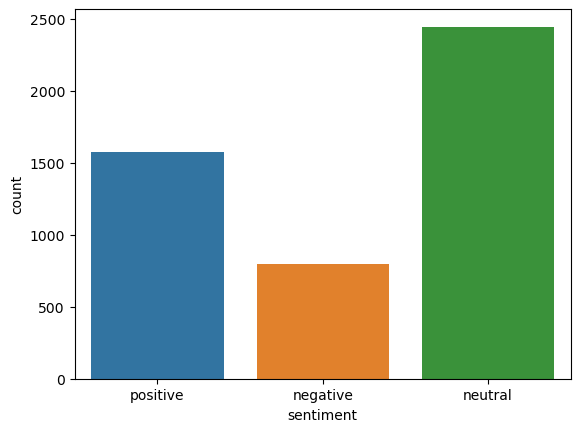

In [98]:
# distribution of sentiment
print(filled_df['sentiment'].value_counts())
sns.countplot(x=filled_df['sentiment'])
plt.show()

Separate words into worldclouds by their sentiment

In [99]:
words = ' '.join([text for text in filled_df['text']])

In [100]:
wordcloud = WordCloud(
    width=800, height=400, background_color='white', max_font_size=110)\
    .generate(words)

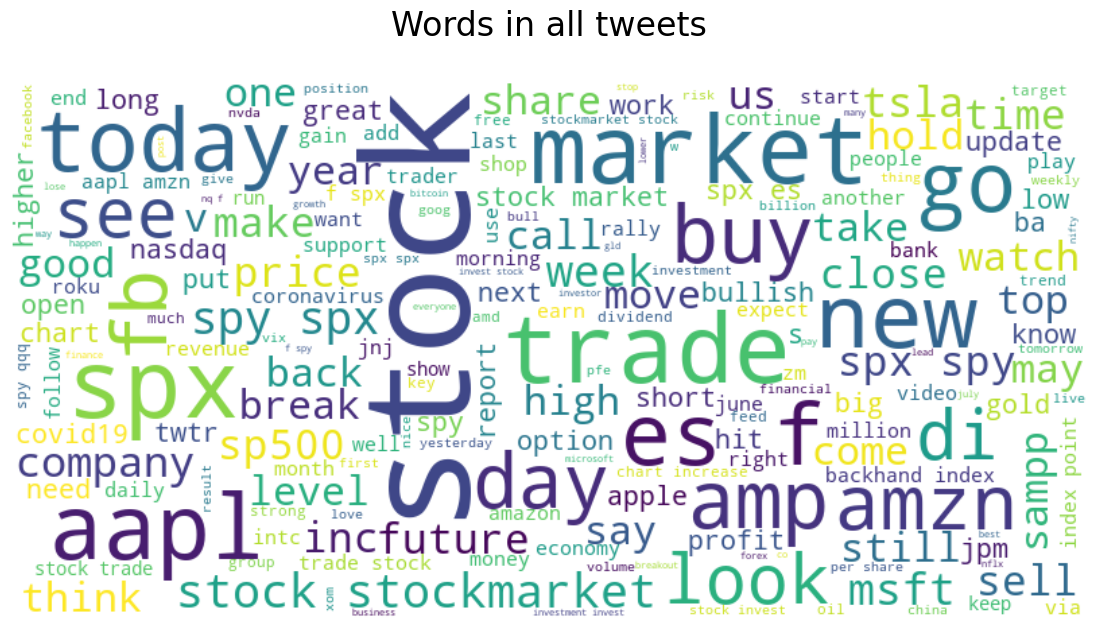

In [101]:
plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Words in all tweets\n', fontsize=24)
plt.axis('off')
plt.show()

#### ADD WORDCLOUD BY SENTIMENT?

## Stock market comparison

We initiate by setting the date as index

In [102]:
import datetime

In [103]:
filled_df['created_at'] = pd.to_datetime(filled_df.created_at).dt.tz_convert(None)

In [104]:
filled_df

,id,created_at,text,sentiment,average_sent,SVC_mul_sent,OVO_mul_sent,DT_mul_sent,NB_mul_sent,sent_polarity
0,77522,2020-04-15 01:03:46,yo collision enter win 1000 monarch tokens che...,positive,1.0,NaN,NaN,NaN,NaN,NaN
1,661634,2020-06-25 06:20:06,srilanka surcharge fuel remove fuel pump chart...,negative,-1.0,NaN,NaN,NaN,NaN,NaN
2,413231,2020-06-04 15:41:45,net issuance increase fund fiscal program gt y...,positive,1.0,NaN,NaN,NaN,NaN,NaN
3,760262,2020-07-03 19:39:35,much amazons traffic serve fastly help us find...,positive,1.0,NaN,NaN,NaN,NaN,NaN
4,830153,2020-07-09 14:39:14,amd ryzen 4000 desktop cpus look ‘great’ track...,positive,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
4807,411380,2020-06-04 18:14:57,ad revenues fall impact social media stock fb ...,positive,1.0,1,1,1,1,0.439683
4808,62318,2020-04-14 02:15:01,well another point add dent current optimism s...,neutral,0.0,0,0,0,1,0.125000
4809,627230,2020-06-23 14:08:15,itox work contract fortune 500 aerospace firm ...,neutral,0.0,0,0,0,1,-0.200000
4810,890123,2020-07-14 23:18:34,dis could break 120 pin 125gt 130,neutral,0.0,0,0,0,1,0.000000


In [105]:
filled_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4812 entries, 0 to 4811
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             4812 non-null   int64         
 1   created_at     4812 non-null   datetime64[ns]
 2   text           4812 non-null   object        
 3   sentiment      4812 non-null   object        
 4   average_sent   4812 non-null   float64       
 5   SVC_mul_sent   3533 non-null   object        
 6   OVO_mul_sent   3533 non-null   object        
 7   DT_mul_sent    3533 non-null   object        
 8   NB_mul_sent    3533 non-null   object        
 9   sent_polarity  3533 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 413.5+ KB


In [106]:
tweets_idxdate = filled_df

In [107]:
tweets_idxdate.index = filled_df.created_at

In [108]:
tweets_idxdate.index

DatetimeIndex(['2020-04-15 01:03:46', '2020-06-25 06:20:06',
               '2020-06-04 15:41:45', '2020-07-03 19:39:35',
               '2020-07-09 14:39:14', '2020-04-12 21:52:56',
               '2020-06-09 05:23:06', '2020-06-02 01:12:29',
               '2020-05-07 04:58:41', '2020-05-04 15:16:29',
               ...
               '2020-06-19 17:57:42', '2020-07-03 13:03:28',
               '2020-06-28 14:12:19', '2020-07-04 22:10:27',
               '2020-06-20 20:34:07', '2020-06-04 18:14:57',
               '2020-04-14 02:15:01', '2020-06-23 14:08:15',
               '2020-07-14 23:18:34', '2020-05-06 04:22:19'],
              dtype='datetime64[ns]', name='created_at', length=4812, freq=None)

In [109]:
daily_tweets = tweets_idxdate[['average_sent']].resample('D').agg('mean')

In [110]:
daily_tweets.shape

(99, 1)

<AxesSubplot:title={'center':'average_sent per day'}, xlabel='Date', ylabel='average_sent'>

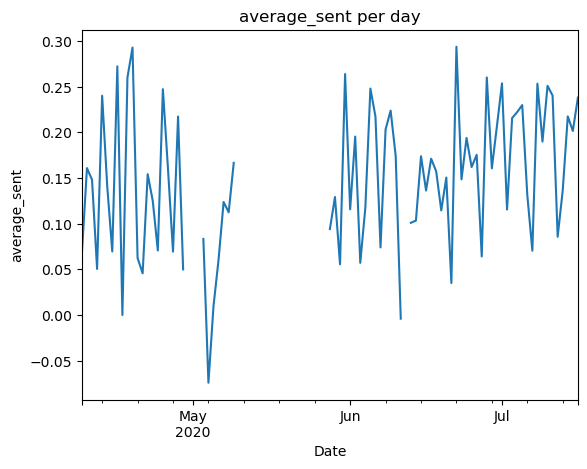

In [111]:
daily_tweets.average_sent.plot(kind='line', xlabel='Date', ylabel='average_sent',
                                    title='average_sent per day')

##### Yahoo Finance Data (AAPL)

In order to compare the impact of sentiment we are taking the historical financial data in this time lapse for S&P500.
The information is obtained from the Yahoo Finance website:
https://finance.yahoo.com/quote/%5EGSPC/history?period1=1586390400&period2=1594857600&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

In [112]:
prices = pd.read_csv ("SP500_prices.csv", error_bad_lines=False, engine='python', sep=',')
prices.head()

/var/folders/k2/_q7jj7754nn3_3h7vr9wvn2c0000gn/T/ipykernel_5555/2832545607.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  prices = pd.read_csv ("SP500_prices.csv", error_bad_lines=False, engine='python', sep=',')


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-07-15,3225.98,3238.28,3200.76,3226.56,3226.56,4.686830e+09
1,2020-07-14,3141.11,3200.95,3127.66,3197.52,3197.52,4.507140e+09
2,2020-07-13,3205.08,3235.32,3149.43,3155.22,3155.22,4.902440e+09
3,2020-07-10,3152.47,3186.82,3136.22,3185.04,3185.04,4.524190e+09
4,2020-07-09,3176.17,3179.78,3115.70,3152.05,3152.05,4.843650e+09


In [113]:
prices.dropna(inplace=True)

In [114]:
prices['Dif_CloseOpen'] = prices['Close'] - prices['Open']
prices.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Dif_CloseOpen
0,2020-07-15,3225.98,3238.28,3200.76,3226.56,3226.56,4.686830e+09,0.58
1,2020-07-14,3141.11,3200.95,3127.66,3197.52,3197.52,4.507140e+09,56.41
2,2020-07-13,3205.08,3235.32,3149.43,3155.22,3155.22,4.902440e+09,-49.86
3,2020-07-10,3152.47,3186.82,3136.22,3185.04,3185.04,4.524190e+09,32.57
4,2020-07-09,3176.17,3179.78,3115.70,3152.05,3152.05,4.843650e+09,-24.12


In [115]:
prices.index = pd.to_datetime(prices['Date'])

In [116]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 67 entries, 2020-07-15 to 2020-04-09
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           67 non-null     object 
 1   Open           67 non-null     float64
 2   High           67 non-null     float64
 3   Low            67 non-null     float64
 4   Close          67 non-null     float64
 5   Adj Close      67 non-null     float64
 6   Volume         67 non-null     float64
 7   Dif_CloseOpen  67 non-null     float64
dtypes: float64(7), object(1)
memory usage: 4.7+ KB


<AxesSubplot:title={'center':'Volume and difference between clsoe and open values'}, xlabel='Date'>

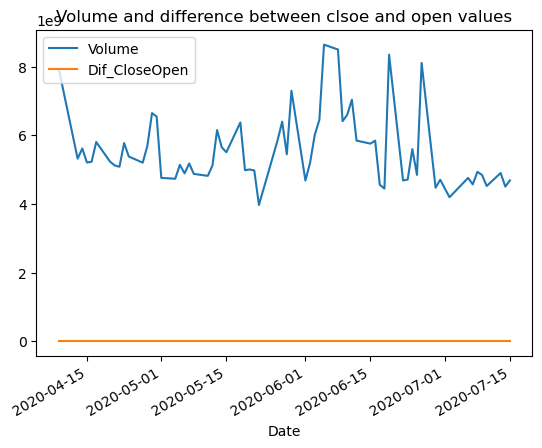

In [117]:
prices[["Volume", "Dif_CloseOpen"]].plot(xlabel='Date', title='Volume and difference between clsoe and open values')

They are very different scales

In [118]:
from sklearn.preprocessing import StandardScaler

In [119]:
s = StandardScaler()

In [120]:
only_prices_and_volumes = prices[["Volume", 'Dif_CloseOpen']]

In [121]:
price_vol_scaled = s.fit_transform(only_prices_and_volumes)

<AxesSubplot:title={'center':'Scaled volume and difference in close and open values'}, xlabel='Date'>

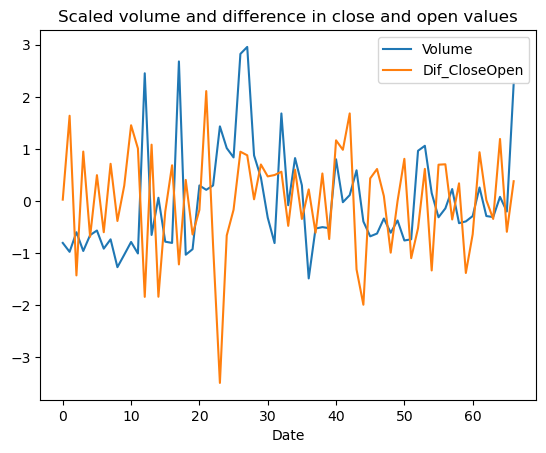

In [122]:
pd.DataFrame(price_vol_scaled, 
             columns=["Volume", 'Dif_CloseOpen']).plot(xlabel='Date', 
                                                       title='Scaled volume and difference in close and open values')

Concatenate prices close with daily tweets

In [123]:
merged = pd.concat([prices.Dif_CloseOpen, daily_tweets.average_sent], axis=1)
merged.head(10)

,Dif_CloseOpen,average_sent
2020-04-09,12.83,6.763285e-02
2020-04-10,NaN,1.609195e-01
2020-04-11,NaN,1.481481e-01
2020-04-12,NaN,5.050505e-02
2020-04-13,-20.83,2.401961e-01
2020-04-14,40.96,1.411765e-01
2020-04-15,-12.28,6.959707e-02
2020-04-16,0.21,2.723005e-01
2020-04-17,32.13,-2.220446e-18
2020-04-18,NaN,2.601626e-01


Remember we have sentiment data for weekends but not for close. We decided to eliminate the null data from our dataset.

In [124]:
merged.dropna(inplace=True)

<AxesSubplot:title={'center':'Difference in close and open with sentiment polarity'}, xlabel='Date'>

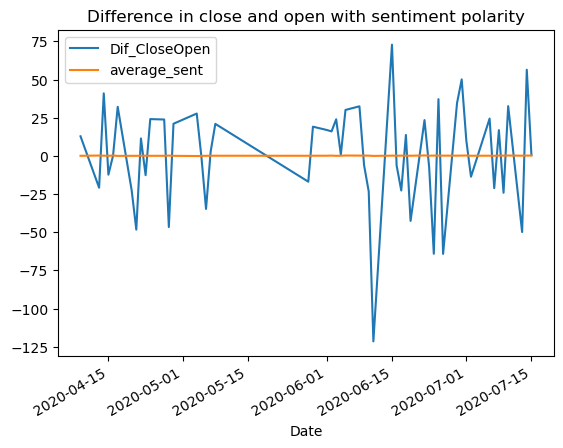

In [125]:
merged.plot(xlabel='Date', title='Difference in close and open with sentiment polarity')

Again, we must set a rescale

In [126]:
s = StandardScaler()

In [127]:
merged_scaled = s.fit_transform(merged)

<AxesSubplot:title={'center':'Scaled difference in close and open with average sentiment'}, xlabel='Date'>

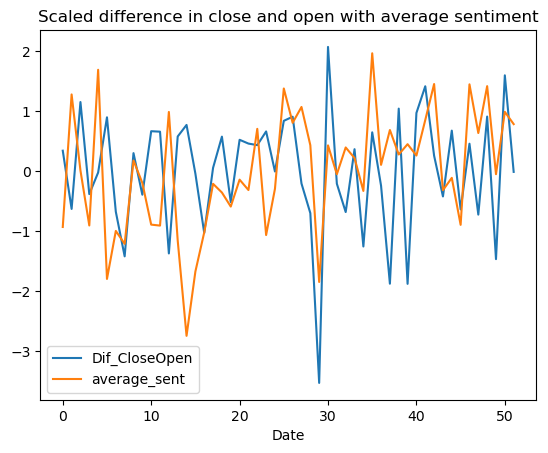

In [128]:
pd.DataFrame(merged_scaled, columns=merged.columns).plot(xlabel='Date', title='Scaled difference in close and open with average sentiment')

We now hace the information of the close and the sentiment for that same day. Given this informaton, could we use the sentiment from the previous day to predict the closeing of the following day.

For this, frst we need to shift the sentiment.

In [129]:
merged['yesterday_sentiment'] = merged['average_sent'].shift(1)
merged.head()

,Dif_CloseOpen,average_sent,yesterday_sentiment
2020-04-09,12.83,0.067633,NaN
2020-04-13,-20.83,0.240196,0.067633
2020-04-14,40.96,0.141176,0.240196
2020-04-15,-12.28,0.069597,0.141176
2020-04-16,0.21,0.272300,0.069597


Again we eliminate the null value

In [130]:
merged.dropna(inplace=True)
merged.head()

,Dif_CloseOpen,average_sent,yesterday_sentiment
2020-04-13,-20.83,2.401961e-01,0.067633
2020-04-14,40.96,1.411765e-01,0.240196
2020-04-15,-12.28,6.959707e-02,0.141176
2020-04-16,0.21,2.723005e-01,0.069597
2020-04-17,32.13,-2.220446e-18,0.272300
